In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd

In [3]:
df = pd.read_csv('fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [5]:
#Assigning Names to Emotions in labels

num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
df.Usage.value_counts() 

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [6]:
k = np.array(list(map(int,df.iloc[0,1].split(" "))),dtype='uint8').reshape((48,48))

In [7]:
k.shape

(48, 48)

In [8]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

In [9]:
X_train[0]

array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

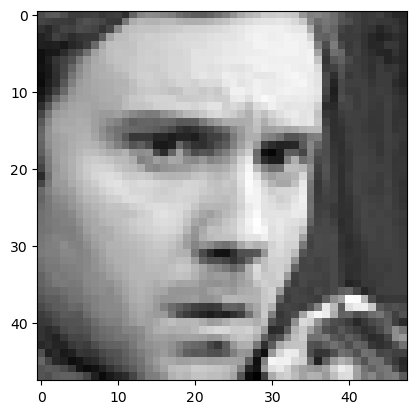

In [10]:
plt.imshow(np.array(X_train[0], dtype = 'uint8').reshape(48,48,1), cmap = 'gray')

In [11]:
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [12]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [13]:
X_train.shape

(28709, 48, 48, 1)

In [14]:
import keras
from keras.utils import to_categorical
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

### Image Augumentation

In [15]:
from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 64

In [16]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

C:\Users\Maverick\AppData\Local\Temp\ipykernel_39508\2156870284.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(330 + 1 + i)


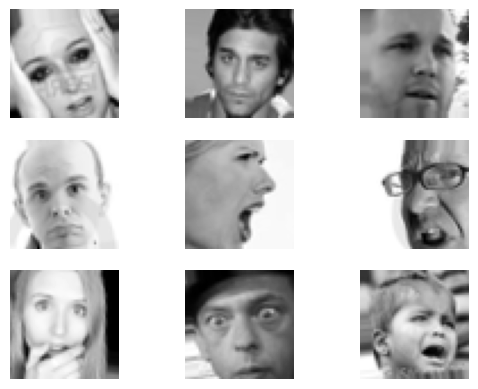

In [17]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        plt.axis('off') 
        plt.subplot(330 + 1 + i) 
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))
    plt.axis('off') 
    plt.show() 
    break

#### Creating Model For Training 

In [21]:
from keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D,Flatten,Dense,Dropout
from keras.models import Sequential

In [23]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

def FER_Model(input_shape=(48, 48, 1)):
    num_classes = 7
    visible = Input(shape=input_shape, name='input')

    # The 1st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name='conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name='conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2, 2), name='pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name='drop1_1')(pool1_1)

    # The 2nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name='conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name='conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name='conv2_3')(conv2_2)
    conv2_3 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2, 2), name='pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name='drop2_1')(pool2_1)

    # The 3rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2, 2), name='pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name='drop3_1')(pool3_1)

    # The 4th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name='conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2, 2), name='pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name='drop4_1')(pool4_1)
    
    # The 5th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name='conv5_4')(conv5_3)
    conv5_4 = BatchNormalization()(conv5_4)
    pool5_1 = MaxPooling2D(pool_size=(2, 2), name='pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name='drop5_1')(pool5_1)

    # Flatten and output
    flatten = Flatten(name='flatten')(drop5_1)
    output = Dense(num_classes, activation='softmax', name='output')(flatten)

    # Create model
    model = Model(inputs=visible, outputs=output)
    # Summary layers
    model.summary()

    return model


In [27]:
model = FER_Model()
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_17 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_18 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0   

ValueError: decay is deprecated in the new Keras optimizer, please check the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.Adam.

In [28]:
from keras.callbacks import ModelCheckpoint
filepath="weights_min_loss.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [30]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

# Assuming you have already defined your model using the FER_Model function
model = FER_Model(input_shape=(48, 48, 1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=categorical_crossentropy,
              metrics=['accuracy'])

# Assuming train_flow and test_flow are defined and properly configured
num_epochs = 100
batch_size = 32  # Set this to your actual batch size

# Use the fit method instead of fit_generator
history = model.fit(
    train_flow,
    steps_per_epoch=len(train_flow) // batch_size,  # using // for integer division
    epochs=num_epochs,
    verbose=2,
    callbacks=callbacks_list,  # make sure callbacks_list is defined earlier in your code
    validation_data=test_flow,
    validation_steps=len(test_flow) // batch_size
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_34 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_35 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0   


Epoch 1: val_loss improved from inf to 1.96177, saving model to weights_min_loss.hdf5


C:\Users\Maverick\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 - 13s - loss: 5.3558 - accuracy: 0.1730 - val_loss: 1.9618 - val_accuracy: 0.1562 - 13s/epoch - 911ms/step
Epoch 2/100

Epoch 2: val_loss improved from 1.96177 to 1.94940, saving model to weights_min_loss.hdf5
14/14 - 8s - loss: 3.4394 - accuracy: 0.1842 - val_loss: 1.9494 - val_accuracy: 0.2031 - 8s/epoch - 552ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.94940
14/14 - 7s - loss: 3.0683 - accuracy: 0.1830 - val_loss: 2.1065 - val_accuracy: 0.1250 - 7s/epoch - 525ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.94940 to 1.83118, saving model to weights_min_loss.hdf5
14/14 - 8s - loss: 2.7432 - accuracy: 0.2199 - val_loss: 1.8312 - val_accuracy: 0.2500 - 8s/epoch - 591ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 1.83118
14/14 - 8s - loss: 2.4457 - accuracy: 0.2455 - val_loss: 2.6234 - val_accuracy: 0.1875 - 8s/epoch - 554ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 1.83118
14/14 - 8s - loss: 2.5225 - accuracy: 0.2188 - val_loss: 

14/14 - 8s - loss: 1.8471 - accuracy: 0.3049 - val_loss: 1.5924 - val_accuracy: 0.3906 - 8s/epoch - 564ms/step
Epoch 48/100

Epoch 48: val_loss did not improve from 1.59235
14/14 - 8s - loss: 1.7900 - accuracy: 0.3627 - val_loss: 1.6220 - val_accuracy: 0.4219 - 8s/epoch - 557ms/step
Epoch 49/100

Epoch 49: val_loss did not improve from 1.59235
14/14 - 8s - loss: 1.8679 - accuracy: 0.2902 - val_loss: 1.9858 - val_accuracy: 0.2500 - 8s/epoch - 553ms/step
Epoch 50/100

Epoch 50: val_loss did not improve from 1.59235
14/14 - 8s - loss: 1.8867 - accuracy: 0.3438 - val_loss: 2.0378 - val_accuracy: 0.2500 - 8s/epoch - 555ms/step
Epoch 51/100

Epoch 51: val_loss did not improve from 1.59235
14/14 - 8s - loss: 1.7644 - accuracy: 0.3482 - val_loss: 1.7037 - val_accuracy: 0.2656 - 8s/epoch - 552ms/step
Epoch 52/100

Epoch 52: val_loss did not improve from 1.59235
14/14 - 8s - loss: 1.7996 - accuracy: 0.3080 - val_loss: 1.7906 - val_accuracy: 0.3125 - 8s/epoch - 555ms/step
Epoch 53/100

Epoch 53: 

Epoch 94/100

Epoch 94: val_loss did not improve from 1.34109
14/14 - 8s - loss: 1.5685 - accuracy: 0.4029 - val_loss: 1.7205 - val_accuracy: 0.4688 - 8s/epoch - 602ms/step
Epoch 95/100

Epoch 95: val_loss did not improve from 1.34109
14/14 - 9s - loss: 1.5328 - accuracy: 0.4152 - val_loss: 1.7086 - val_accuracy: 0.2812 - 9s/epoch - 607ms/step
Epoch 96/100

Epoch 96: val_loss did not improve from 1.34109
14/14 - 8s - loss: 1.5964 - accuracy: 0.3795 - val_loss: 1.4710 - val_accuracy: 0.4531 - 8s/epoch - 592ms/step
Epoch 97/100

Epoch 97: val_loss did not improve from 1.34109
14/14 - 8s - loss: 1.5530 - accuracy: 0.4007 - val_loss: 1.5351 - val_accuracy: 0.3594 - 8s/epoch - 580ms/step
Epoch 98/100

Epoch 98: val_loss did not improve from 1.34109
14/14 - 8s - loss: 1.5770 - accuracy: 0.3962 - val_loss: 1.7325 - val_accuracy: 0.4062 - 8s/epoch - 586ms/step
Epoch 99/100

Epoch 99: val_loss did not improve from 1.34109
14/14 - 8s - loss: 1.5824 - accuracy: 0.4085 - val_loss: 1.5751 - val_acc

### for testing

<Figure size 640x480 with 0 Axes>

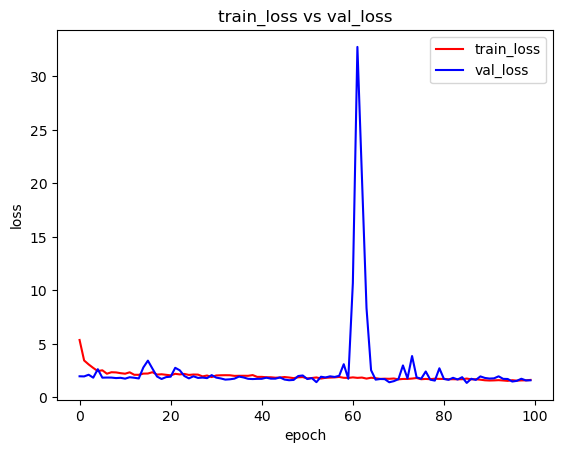

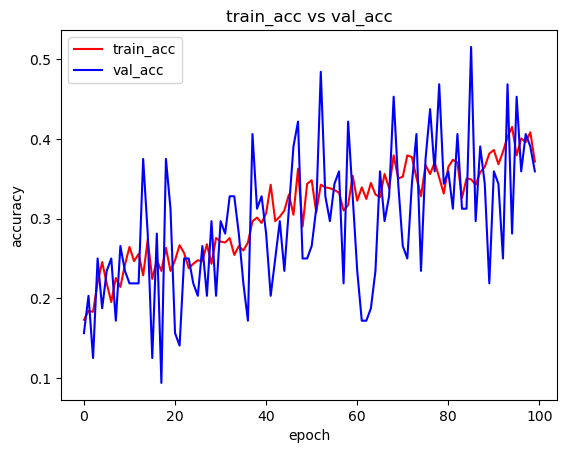

<Figure size 640x480 with 0 Axes>

In [31]:
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [32]:
model.save('Fer2013.h5')


In [33]:
loss = model.evaluate(X_test/255., y_test) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 10s 83ms/step - loss: 1.5496 - accuracy: 0.3909
Test Loss 1.549628734588623
Test Acc: 0.3909166753292084


In [35]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
